# Symphony benchmarking
Comparison of results obtained by R and Python implementations

Harmony R -> Symphony R  
vs  
Harmony R -> symphonypy

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

sc.set_figure_params(dpi=150)

JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)
DATA_DIR = os.path.join(os.path.dirname(JUPYTER_DIR), "data")

sys.path.append(SYMPHONY_DIR)

import symphonypy as sp

In [2]:
%load_ext rpy2.ipython
import rpy2
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda x: print(x, end="")

In [3]:
adata = sc.read_h5ad(os.path.join(DATA_DIR, "PBMC_Satija.h5ad"))

In [4]:
adata

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'

In [5]:
adata.layers["counts"] = adata.X.copy()

In [6]:
# Preprocessing

n_comps = 30
max_value = 10
n_neighbors = 21

adata.var_names_make_unique()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="donor")
adata.raw = adata
sc.pp.scale(adata, max_value=max_value)
sc.pp.pca(adata, n_comps=n_comps)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


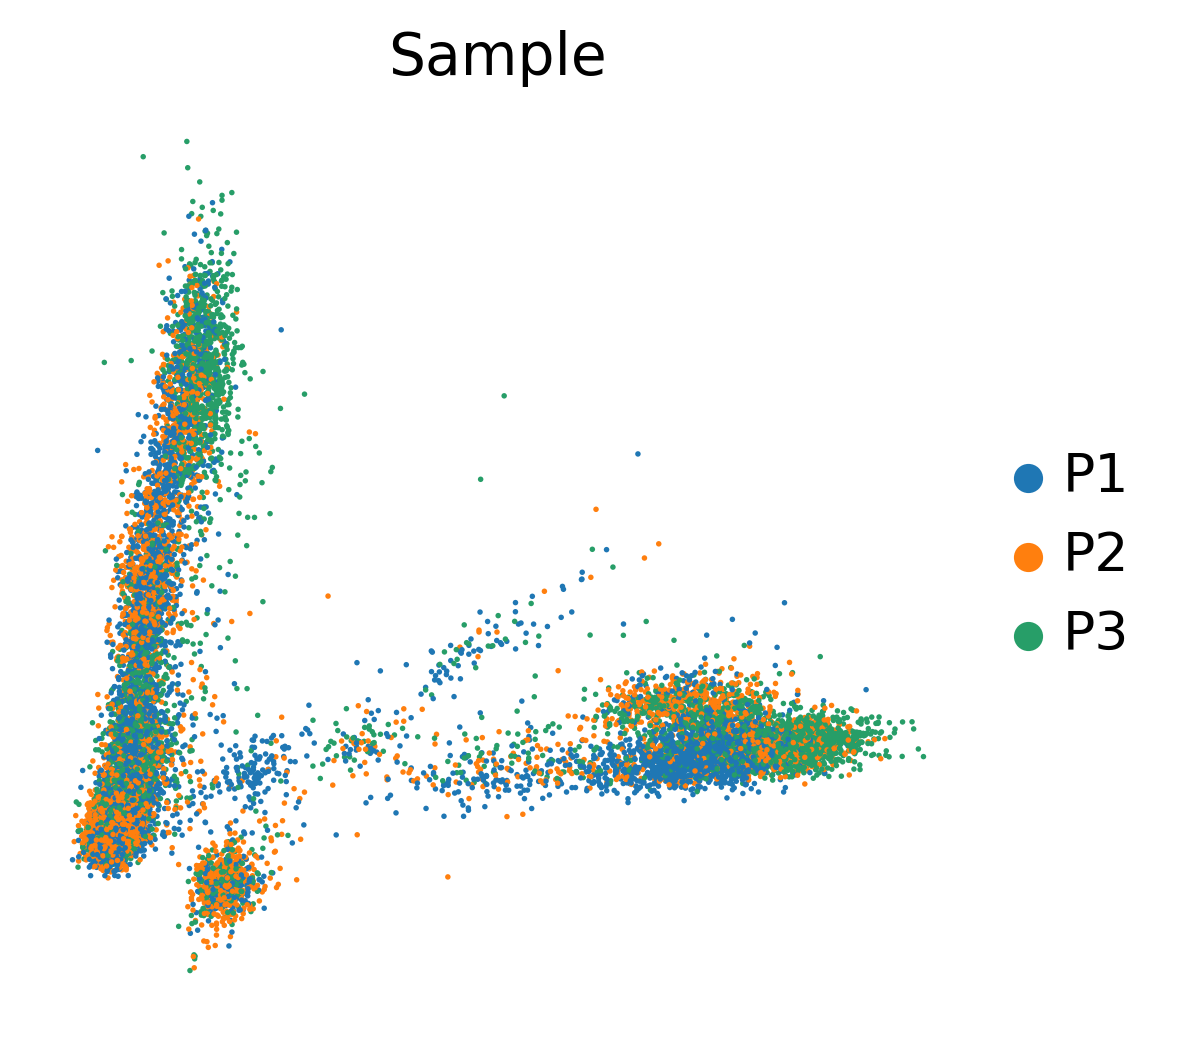

In [7]:
sc.pl.pca(adata, color="donor", frameon=False, title="Sample")

## Harmony

In [8]:
my_pca_embeddings = adata.obsm["X_pca"].copy()
meta_data = adata.obs.copy()

### Harmony R

In [9]:
%%R -i my_pca_embeddings -i meta_data
library(harmony)
harmony_object <- HarmonyMatrix(
  my_pca_embeddings,
  meta_data,
  "donor",
  do_pca = FALSE,
  max.iter.harmony = 20,
  return_object = TRUE
)

Loading required package: Rcpp
Harmony 1/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 2/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 3/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 4/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 5/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 6/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|

In [10]:
%%R -o X_pca_harmony_R
X_pca_harmony_R <- harmony_object$Z_corr

## Symphony

In [11]:
adata_reference = adata.copy()

adata_query = sc.datasets.pbmc3k()
adata_query.var_names_make_unique()

sc.pp.normalize_total(adata_query)
sc.pp.log1p(adata_query)

### Harmony R -> Symphonypy

In [12]:
%%R -o R,K,sigma
R <- harmony_object$R
K <- harmony_object$K
sigma <- harmony_object$sigma

In [13]:
adata_reference

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'donor_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

Take all the Harmony parameters from R Harmony object to be able to compare Symphony R with Symphonypy independently from difference between Harmony R and Harmonypy

In [14]:
# [K, d] = [K, Nref] x [d, N_ref].T
C = R @ X_pca_harmony_R.T
Y = C / np.linalg.norm(C, ord=2, axis=1, keepdims=True)

adata_reference.uns["harmony"] = {
    # [K] the number of cells softly belonging to each cluster
    "Nr": R.sum(axis=1),
    # [K, d]
    "C": C,
    # ref cluster centroids L2 normalized
    # [K, d]
    "Y": Y,
    # number of clusters
    "K": K[0],
    # sigma [K] (cluster cross enthropy regularization coef)
    "sigma": sigma.squeeze(1),
    "ref_basis_loadings": "PCs",
    "ref_basis_adjusted": "X_pca_harmony",
}

adata_reference.obsm["X_pca_harmony_R_py"] = X_pca_harmony_R.T.copy() 

In [15]:
adata_query.obs["donor"] = 1

In [16]:
sp.tl.map_embedding(
    adata_reference,
    adata_query,
    key="donor",
    adjusted_basis_query="X_pca_harmony_R_py",
    query_basis_ref="X_pca_reference"
)

448 out of 3000 genes from reference are missing in query dataset or have zero std in reference,their expressions in query will be set to zero


/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


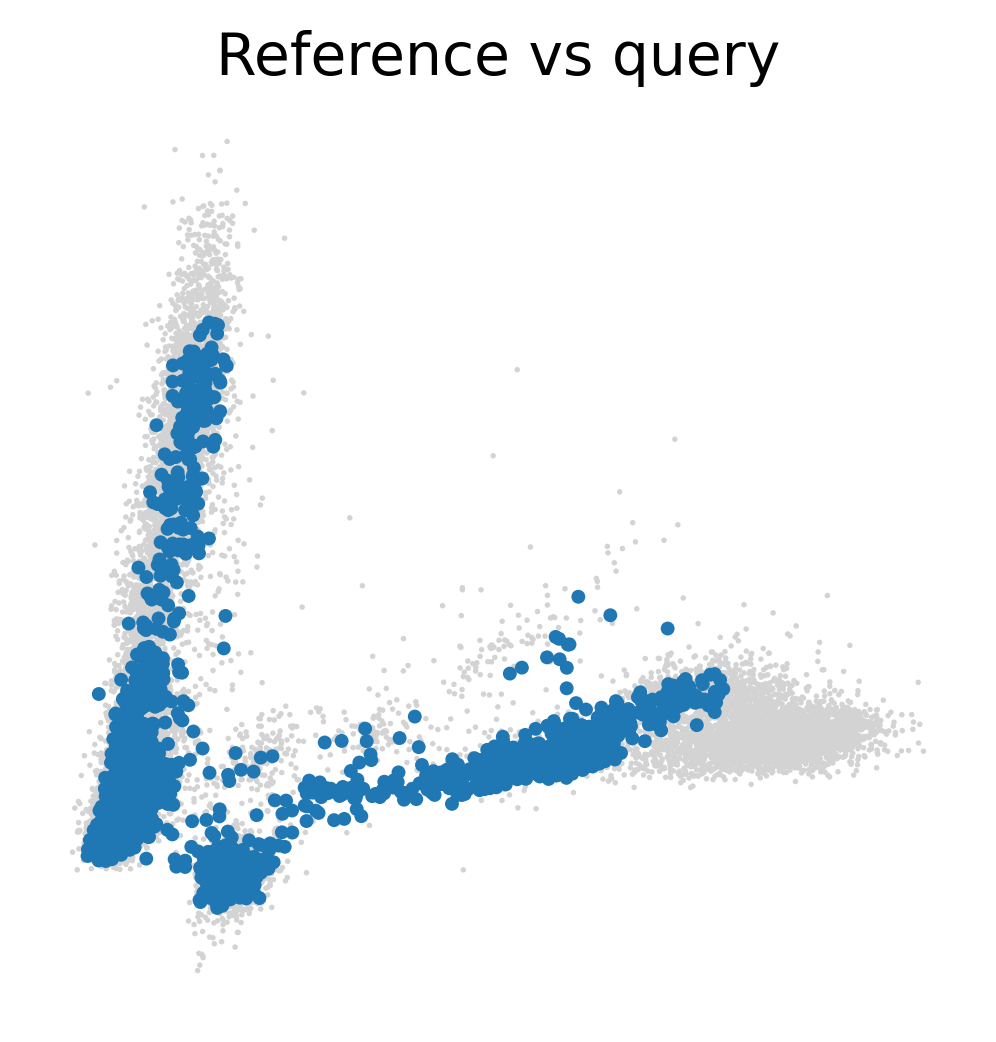

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
adata_query.obs["Reference vs query"] = "query"
sc.pl.embedding(adata_reference, basis="X_pca_harmony_R_py", ax=ax, show=False, frameon=False)
sc.pl.embedding(adata_query, basis="X_pca_harmony_R_py", ax=ax, show=False, color="Reference vs query",
                legend_loc=None, frameon=False)
del adata_query.obs["Reference vs query"]
del adata_query.uns["Reference vs query_colors"]

In [18]:
labels = ['celltype.l1', 'celltype.l2', 'celltype.l3']
n_neighbours = 20
basis_adjusted = "X_pca_harmony_R_py"

In [19]:
sp.tl.transfer_labels_kNN(
    adata_reference,
    adata_query,
    labels,
    # kNN args
    n_neighbours,
    ref_basis=basis_adjusted,
    query_basis=basis_adjusted,
    # kNN kwargs
    weights="distance",
)

sc.pp.neighbors(
    adata_reference, n_pcs=n_comps, n_neighbors=n_neighbours, knn=True, use_rep=basis_adjusted
)
sc.tl.umap(adata_reference)

In [20]:
# the problem is that sc.tl.ingest makes unnecessary check
# that all var_names in adata_query and adata_ref are the same :(
# there are issues on scanpy github concerning this problem
common_genes = list(set(adata_query.var_names).intersection(adata_reference.var_names))

adata_query_t = adata_query[:,common_genes].copy()

sc.tl.ingest(adata=adata_query_t, adata_ref=adata_reference[:,common_genes], embedding_method="umap")
adata_query_t

AnnData object with n_obs × n_vars = 2700 × 15391
    obs: 'donor', 'celltype.l1', 'celltype.l2', 'celltype.l3'
    var: 'gene_ids'
    uns: 'log1p'
    obsm: 'X_pca_reference', 'X_pca_harmony_R_py', 'rep', 'X_umap'

In [21]:
adata_query.obsm["X_umap"] = adata_query_t.obsm["X_umap"]

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


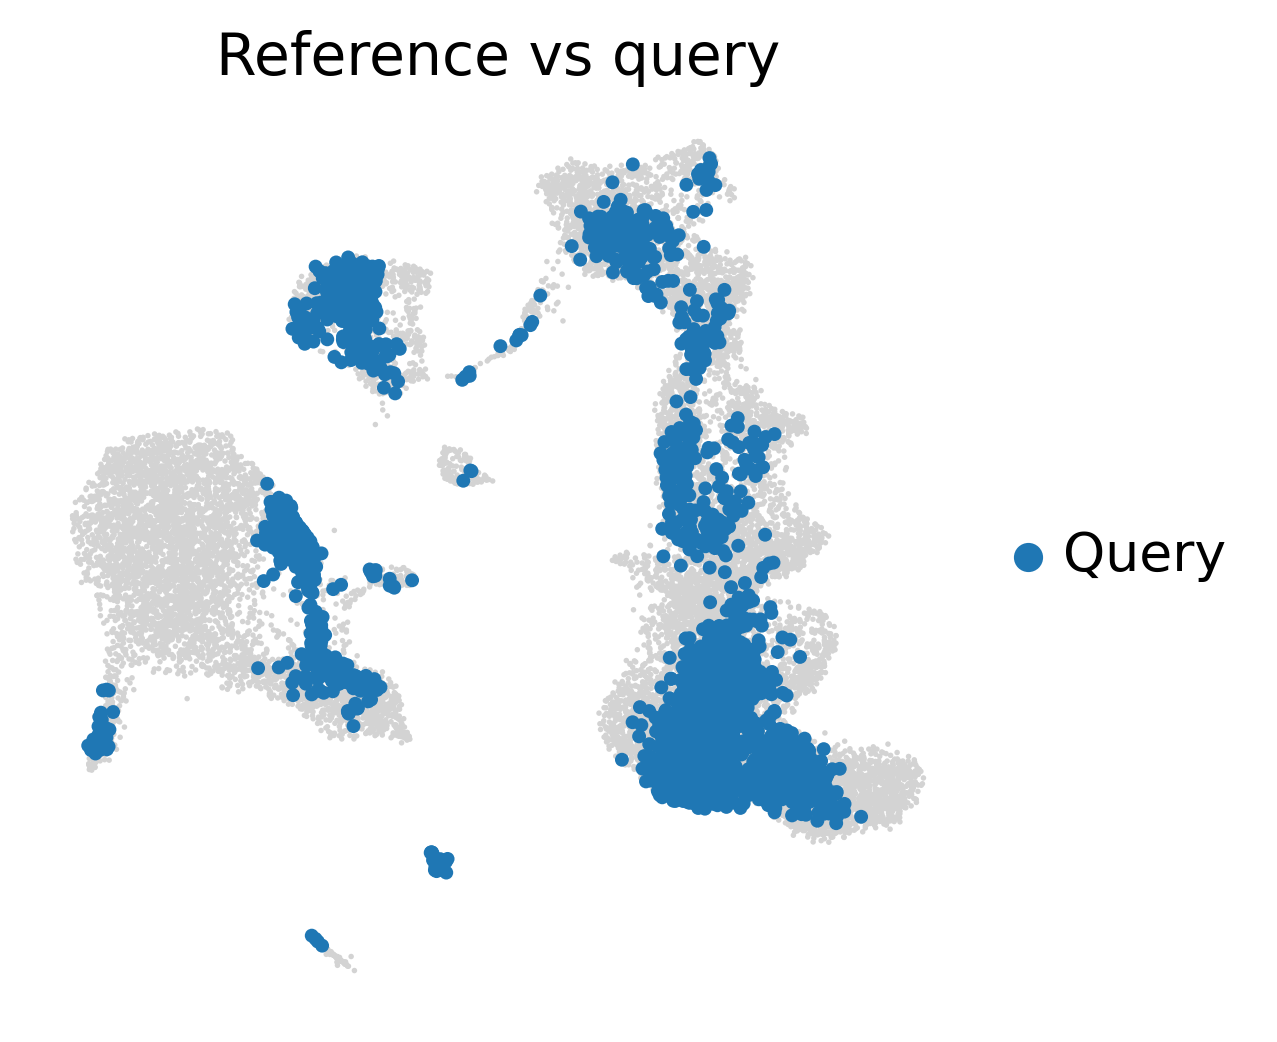

In [22]:
fig, ax = plt.subplots()
adata_query.obs["Reference vs query"] = "Query"
sc.pl.embedding(adata_reference, basis="X_umap", ax=ax, show=False, frameon=False)
sc.pl.embedding(adata_query, basis="X_umap", ax=ax, show=False, color="Reference vs query", frameon=False)
del adata_query.obs["Reference vs query"]

In [23]:
plt.rcParams.update({'legend.fontsize': 5})

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping

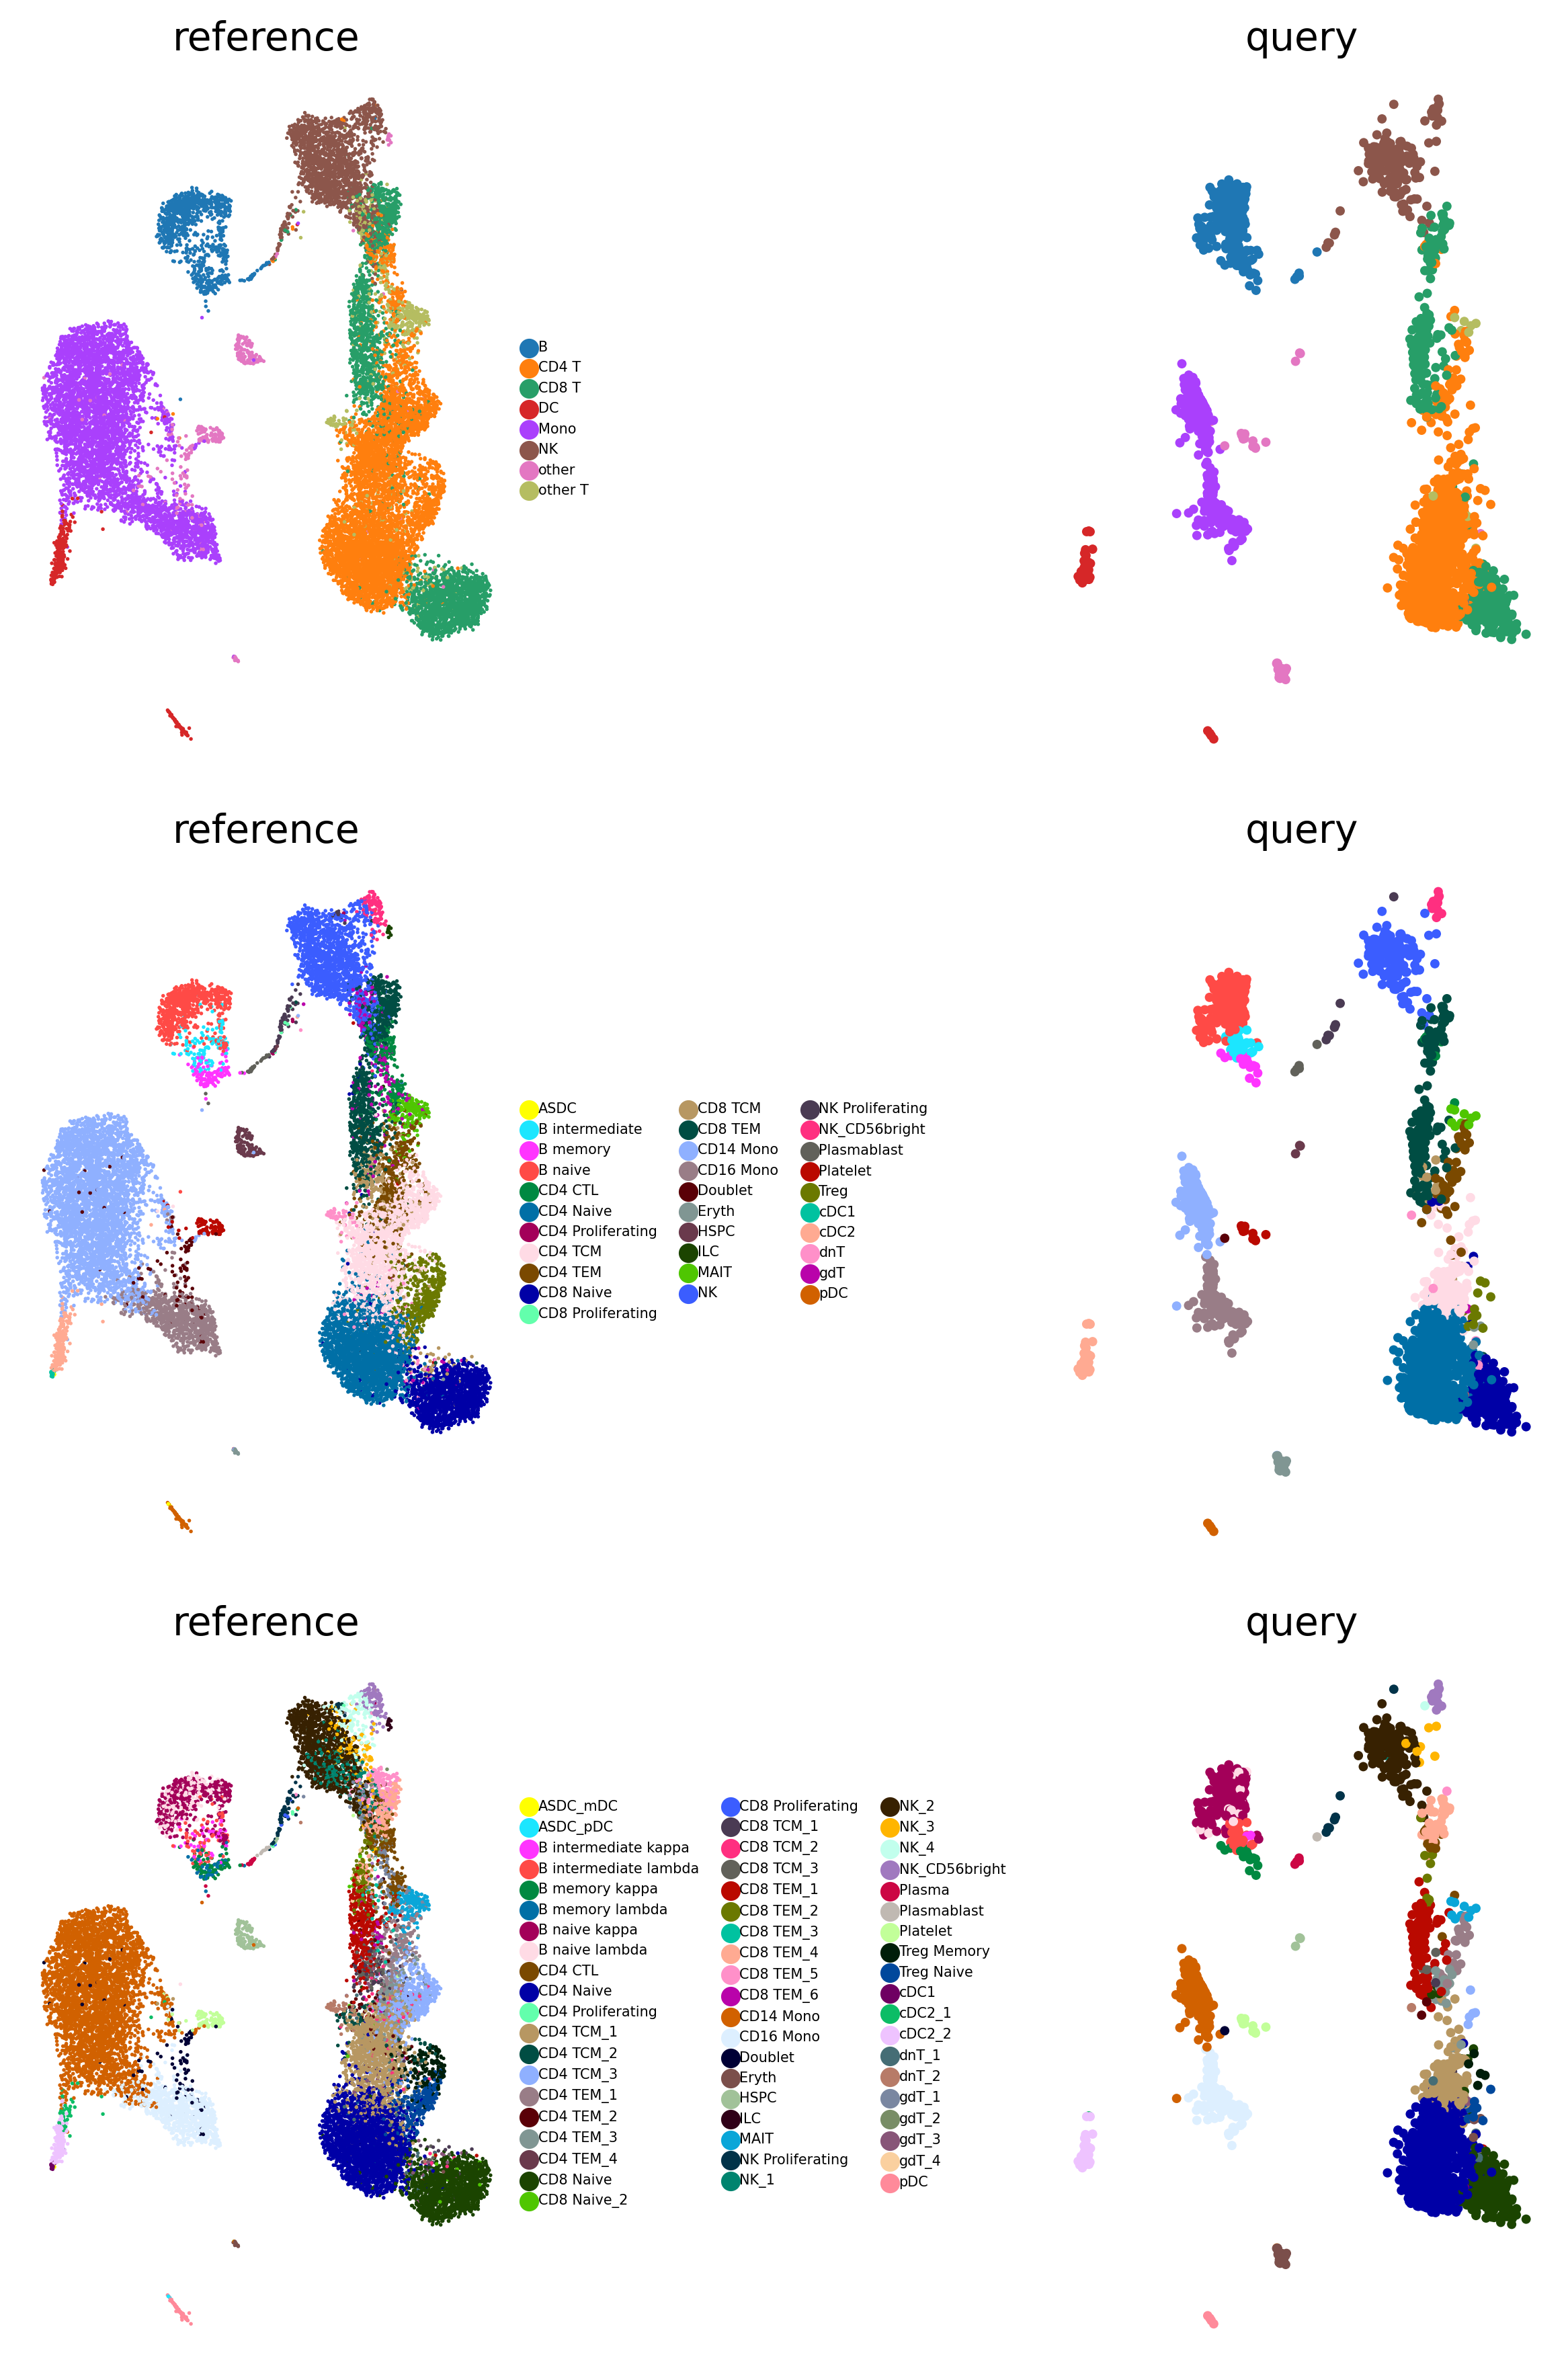

In [24]:
fig, axs = plt.subplots(3,2, figsize=(8, 3*4))

sc.pl.embedding(adata_reference, basis="X_umap", ax=axs[0][0], show=False, frameon=False, color="celltype.l1", title="reference")
ref_l1 = adata_reference.obs["celltype.l1"].unique().sort_values()
adata_query.uns['celltype.l1_colors'] = np.array(adata_reference.uns["celltype.l1_colors"])[ref_l1.isin(adata_query.obs["celltype.l1"].unique().sort_values())]
sc.pl.embedding(adata_query, basis="X_umap", ax=axs[0][1], show=False, color="celltype.l1", frameon=False, title="query", legend_loc=None)

sc.pl.embedding(adata_reference, basis="X_umap", ax=axs[1][0], show=False, frameon=False, color="celltype.l2", title="reference")
ref_l2 = adata_reference.obs["celltype.l2"].unique().sort_values()
adata_query.uns['celltype.l2_colors'] = np.array(adata_reference.uns["celltype.l2_colors"])[ref_l2.isin(adata_query.obs["celltype.l2"].unique().sort_values())]
sc.pl.embedding(adata_query, basis="X_umap", ax=axs[1][1], show=False, color="celltype.l2", frameon=False, title="query", legend_loc=None)

sc.pl.embedding(adata_reference, basis="X_umap", ax=axs[2][0], show=False, frameon=False, color="celltype.l3", title="reference")
ref_l3 = adata_reference.obs["celltype.l3"].unique().sort_values()
adata_query.uns['celltype.l3_colors'] = np.array(adata_reference.uns["celltype.l3_colors"])[ref_l3.isin(adata_query.obs["celltype.l3"].unique().sort_values())]
sc.pl.embedding(adata_query, basis="X_umap", ax=axs[2][1], show=False, color="celltype.l3", frameon=False, title="query", legend_loc=None)

fig.tight_layout()

### Harmony R -> Symphony R

In [25]:
var_genes = adata_reference.var_names[adata_reference.var.highly_variable]
gene_means = adata_reference.var.loc[var_genes, "mean"]
gene_sds = adata_reference.var.loc[var_genes, "std"]
loadings = adata_reference.varm["PCs"][adata_reference.var.highly_variable]

In [26]:
%%R -i var_genes,gene_means,gene_sds

vargenes_means_sds <- data.frame(symbol = var_genes, mean = gene_means, stddev=gene_sds)

In [27]:
%%R -i loadings
# Compress a Harmony object into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           harmony_object,            # output object from HarmonyMatrix()
                           meta_data,           # reference cell metadata
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs matrix
                           )

Save metadata, vargenes (S), and loadings (U)
Save R, Z_orig, Z_corr, and betas from Harmony object
Calculate final L2 normalized reference centroids (Y_cos)
Calculate reference compression terms (Nr and C)
UMAP
Finished nicely.


In [28]:
query_exp = adata_query.X.A.T
query_metadata = adata_query.obs
gene_names = adata_query.var_names

In [29]:
%%R -i query_exp,query_metadata,gene_names
rownames(query_exp) <- gene_names

In [30]:
%%R
# Map query
query = symphony::mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 reference,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k+1) normalization on query
                 do_umap = FALSE,
                 )

Scaling and synchronizing query gene expression
Found 2552 out of 3000 reference variable genes in query dataset
Project query cells using reference gene loadings
Clustering query cells to reference centroids
Correcting query batch effects
All done!


In [31]:
%%R -o X_pca_harmony_R_R
# names(query)
X_pca_harmony_R_R <- query$Z

### Symphony R vs Symphonypy

In [32]:
adata_query.obsm["X_pca_harmony_R_R"] = X_pca_harmony_R_R.T

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


<AxesSubplot: xlabel='X_pca_harmony_R_py1', ylabel='X_pca_harmony_R_py2'>

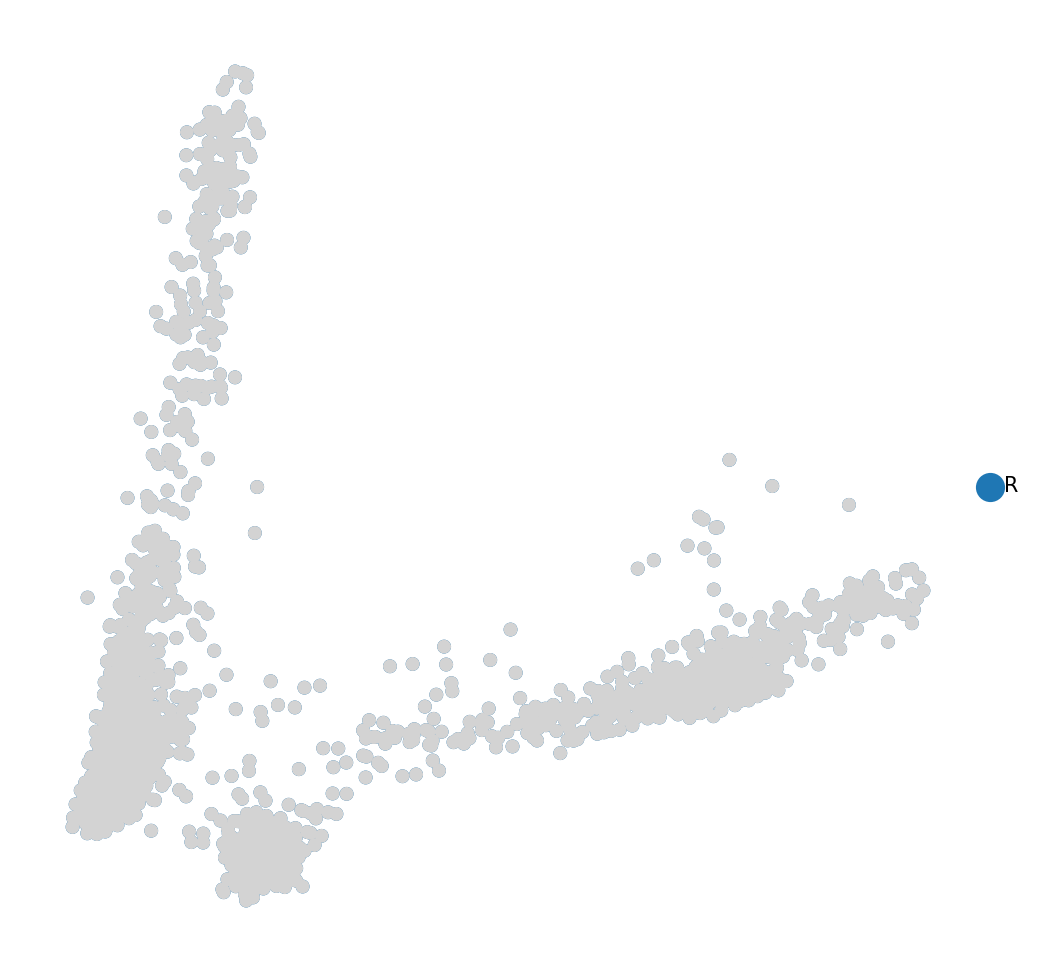

In [33]:
fig, ax = plt.subplots()
adata_query.obs["Symphony R vs Python"] = "R"
sc.pl.embedding(adata_query, basis="X_pca_harmony_R_R", ax=ax, show=False, frameon=False, color="Symphony R vs Python")
sc.pl.embedding(adata_query, basis="X_pca_harmony_R_py", ax=ax, show=False, frameon=False)

In [34]:
dif = abs(adata_query.obsm["X_pca_harmony_R_R"] - adata_query.obsm["X_pca_harmony_R_py"]).flatten()

In [35]:
any(dif > 1e-10)

False

Text(0.5, 1.0, 'abs(X_pca_symphony_R - X_pca_symphonypy).flatten()')

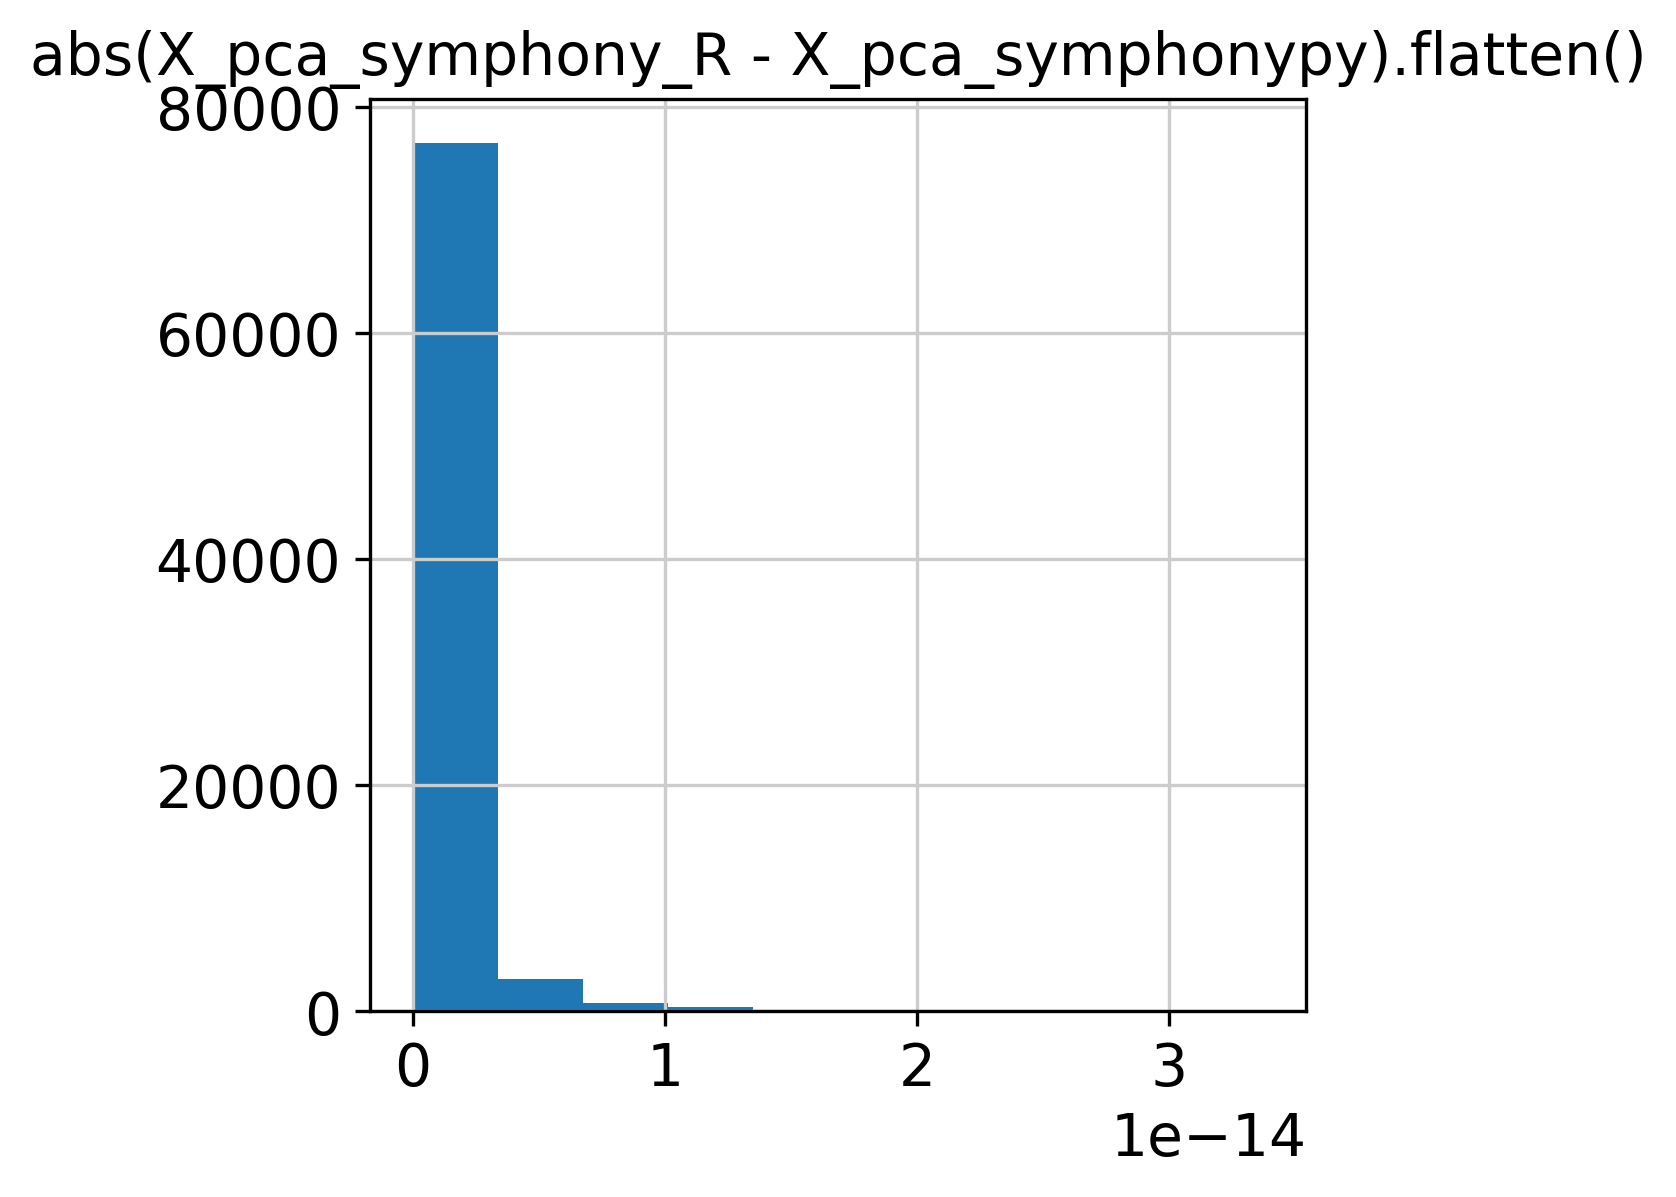

In [36]:
_ = plt.hist(dif)
plt.title("abs(X_pca_symphony_R - X_pca_symphonypy).flatten()")